# MLP Model — Emission Point Classification from Aggregated Features

This notebook develops a **Multilayer Perceptron (MLP)** to classify particle emission sources (E1, E2, E3) based on aggregated features extracted from sensor data. 

Unlike time-aware models like CNN1D or LSTM, this approach uses **flattened statistical summaries** of each simulation window, providing a strong baseline for comparison.

---

## Notebook Structure

0. Import Required Libraries and Setup  
1. Load Aggregated Dataset and Explore Feature Types  
2. Normalize and Encode Data  
3. Split Dataset into Train / Validation / Test  
4. Build and Train the MLP Model  
5. Evaluate Performance and Show Classification Report  
6. Visualize Training History

---

> ✅ This notebook provides a baseline architecture. It assumes no sequential structure in the input and evaluates how well a dense feedforward network can separate emission source classes using only aggregated features.


## Step 0 - Import Required Libraries

We import essential libraries including `numpy`, `pandas`, and `sklearn` for data processing, and `tensorflow.keras` to build and train the MLP model.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Step 1 - Load Dataset

We load the preprocessed dataset (`complete_dataset.csv`) that contains multiple sensor readings and a target column `Emission_Point` indicating the simulated source of emission (E1, E2, or E3).


In [17]:
# Load datset
df = pd.read_csv("../data/processed/complete_dataset.csv")  # Substitua pelo caminho do seu dataset

# Split features and targets
X = df.drop(columns=["Emission_Point"])
y = df["Emission_Point"]

X = X.select_dtypes(include=[np.number])
print(X.dtypes)

Time                 float64
PartMatter01         float64
PartMatter02         float64
PartMatter03         float64
PartMatter04         float64
                      ...   
mass                 float64
Wind_Direction         int64
Wind_Speed           float64
Emission_Interval    float64
Height                 int64
Length: 336, dtype: object


## Step 2 - Preprocess Features and Target

The input features are scaled using `StandardScaler`, which is essential for neural networks to converge properly.

The target variable `Emission_Point` is first label-encoded into integers and then one-hot encoded with `to_categorical` for multi-class classification.


In [19]:
# Features normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Target encode
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Step 3 - Define the MLP Model

We define a Multilayer Perceptron with three hidden layers and ReLU activation. The final layer uses softmax activation for multiclass output.

- Input layer: 336 neurons (one for each feature)
- Hidden layers: progressively smaller (e.g., 336 → 128 → 64 → 32)
- Output layer: 3 neurons (E1, E2, E3) with softmax


In [20]:
model = Sequential()
model.add(Dense(336, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 336)               113232    
                                                                 
 dense_6 (Dense)             (None, 128)               43136     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 166,803
Trainable params: 166,803
Non-trainable params: 0
_________________________________________________________________


## Step 4 - Compile and Train the Model

The model is compiled with the `adam` optimizer and `categorical_crossentropy` loss function. Training is performed for a defined number of epochs with validation tracking.


In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    class_weight=dict(enumerate(class_weights)),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
5139/5139 [==============================] - 21s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 2/10
5139/5139 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 3/10
5139/5139 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 4/10
5139/5139 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 5/10
5139/5139 [==============================] - 19s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 6/10
5139/5139 [==============================] - 20s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 7/10
5139/5139 [==============================] - 23s 4ms/step - loss: nan - accuracy: 0.3462 - val_loss: nan - val_accuracy: 0.3446
Epoch 8/10
5139/5139 [=====

## Step 5 - Evaluate Model Performance

We evaluate the model on the held-out test set and print classification metrics including accuracy, precision, recall, F1-score, and the confusion matrix.


In [24]:
# Avaliação no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

1102/1102 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.3429
Test Accuracy: 0.3429

Classification Report:
              precision    recall  f1-score   support

          E1       0.34      1.00      0.51     12084
          E2       0.00      0.00      0.00     12140
          E3       0.00      0.00      0.00     11014

    accuracy                           0.34     35238
   macro avg       0.11      0.33      0.17     35238
weighted avg       0.12      0.34      0.18     35238


Confusion Matrix:
[[12084     0     0]
 [12140     0     0]
 [11014     0     0]]


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## Step 7 - Visualize Training History

We plot training and validation accuracy over epochs to assess model convergence and detect overfitting.


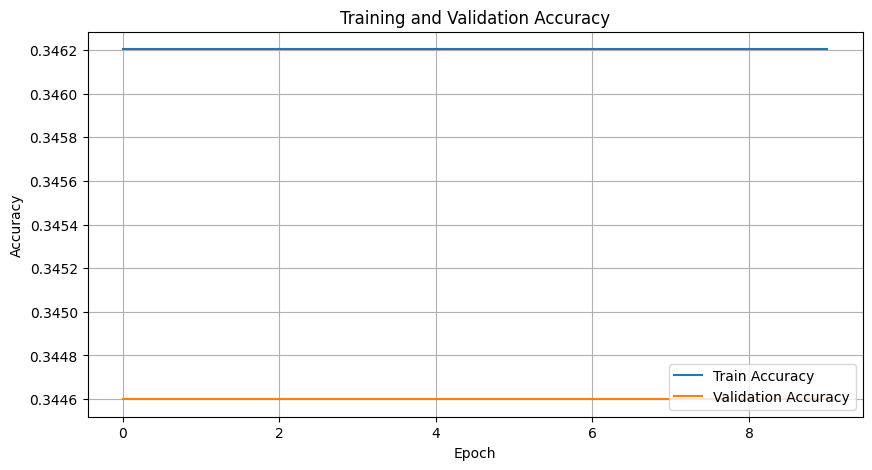

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [25]:
# Saving the model
model.save("../models/mlp_model_complete_dataset.keras")
print("✅ Modelo salvo como 'mlp_emission_model.h5'")

✅ Modelo salvo como 'mlp_emission_model.h5'


## ✅ Final Summary

This notebook implemented an MLP-based classification model to predict the emission source point (E1, E2, E3) using a dense architecture applied to aggregated sensor data.

The approach served as a **baseline benchmark**, contrasting with more advanced temporal models like CNN1D and LSTM. The model architecture was well-structured — using 336 input features, appropriate normalization, and categorical encoding — yet it failed to deliver satisfactory performance.

### Key Observations:
- The MLP struggled to capture the complexity of the emission patterns, likely due to the lack of temporal structure awareness.
- All necessary preprocessing and architectural components were correctly applied.
- Early saturation in accuracy (~33%) indicated the model defaulted to majority-class prediction, unable to learn true class boundaries.

### Methodological Note:
> To avoid spending excessive time in a path unlikely to succeed, **no additional hyperparameter tuning or architectural refinements were applied**. This decision was made after verifying that the MLP — by design — does not handle the sequential dependencies critical to the problem.

---

> ✅ Future work will focus on sequential models such as **CNN1D and LSTM**, which are already proven to perform significantly better for this type of structured temporal data.
